# Packet Breakdown 

## Importando bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid') # change de style here!

%matplotlib inline

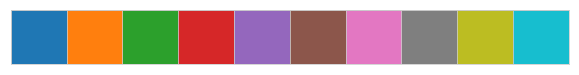

In [2]:
sns.palplot(sns.color_palette())

In [3]:
# deixar a pasta scripts vizivel no notebook
%load_ext autoreload
%autoreload 2

import sys
import os

module_path = os.path.abspath(os.path.join('..', 'pyscripts'))
if module_path not in sys.path :
    sys.path.append(module_path)

In [4]:
# import module from scripts folder
import process_data

## Pre processing 

In [5]:
## import dataset from ../data
data_folder = os.path.join('..','Simulations')

simulations = ['PA','PB','CL2','CL4','CLBinomial']

# the same file will be searching
main_file = 'packet_breakdown.txt' 

df_data = pd.DataFrame()

for folder in simulations:
    data_file = os.path.join(data_folder,folder,main_file)
    df = process_data.parser_main_table(data_file)
    df['Simulation'] = folder
    df_data = df_data.append(df,ignore_index=True)

del df


In [6]:
df_data.sample(5)

,info_0,info_1,info_2,"Failed, buffer overflow","Failed, busy channel","Failed, no ack","Success, first try","Success, not first try",Simulation
41,setRateLow,InterfModel=0,node=2,0,0,0.02615,0.87813,0.09572,PB
3,setRateHigh,InterfModel=0,node=4,0.12637,0.01254,0.01919,0.70874,0.13315,PA
29,setRateMedium,InterfModel=2,node=5,0,0,0.0292,0.93159,0.03921,PA
138,setRateLow,InterfModel=2,node=4,0,0,0.03005,0.89037,0.07958,CLBinomial
56,setRateMedium,InterfModel=2,node=2,0,0.00167,0.03506,0.8709,0.09238,PB


In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
info_0                     150 non-null object
info_1                     150 non-null object
info_2                     150 non-null object
Failed, buffer overflow    150 non-null object
Failed, busy channel       150 non-null object
Failed, no ack             150 non-null object
Success, first try         150 non-null object
Success, not first try     150 non-null object
Simulation                 150 non-null object
dtypes: object(9)
memory usage: 10.6+ KB


### Normalizando os dados

In [8]:
numericColumns = [
    'Failed, buffer overflow',
    'Failed, busy channel' ,
    'Failed, no ack',
    'Success, first try',
    'Success, not first try'
]

df_data[numericColumns] = df_data[numericColumns].astype('float')
df_data[numericColumns] *= 100

In [9]:
nodes_PTbr = {
        'node=1': 'E-Punho',
        'node=2': 'D-Punho',
        'node=3': 'E-Tornozelo',
        'node=4': 'D-Tornozelo',
        'node=5': 'Peito',
        'node=0': 'Sink'
    }

nodes_ENG = {
        'node=1': 'L-wrist',
        'node=2': 'R-wrist',
        'node=3': 'L-ankle',
        'node=4': 'R-ankle',
        'node=5': 'chest',
        'node=0': 'sink'
    }

def infer_node(value,mapper=nodes_PTbr):
    return mapper.get(value,value)

df_data['info_2'] = df_data['info_2'].apply(infer_node)

In [10]:
taxa_dados = {
    'setRateLow' : 'baixa',
    'setRateMedium': 'média',
    'setRateHigh' : 'alta'
}

packet_rate = {
    'setRateLow' : 'low',
    'setRateMedium': 'medium',
    'setRateHigh' : 'high'
}

def infer_packet_rate(value,mapper=taxa_dados):
    return mapper.get(value,value)

df_data['info_0'] = df_data['info_0'].apply(infer_packet_rate)

In [11]:
modelo_colisao = {
    'InterfModel=0': 'sem colisão',
    'InterfModel=2': 'com colisão'
}

collision_model = {
    'InterfModel=0': 'without collision',
    'InterfModel=2': 'with collision'
}

def infer_collision_model(value,mapper=modelo_colisao):
    return mapper.get(value,value)

df_data['info_1'] = df_data['info_1'].apply(infer_collision_model)

### Renomeando colunas

In [12]:
columns_portuguese = {
    'info_0' : 'Taxa dados',
    'info_1' : 'Modelo de colisão',
    'info_2' : 'Nó sensor',
    'Failed, buffer overflow': 'Falha, estouro de buffer',
    'Failed, busy channel' : 'Falha, canal ocupado',
    'Failed, no ack': 'Falha, não recebimento ACK', 
    'Success, first try' : 'Sucesso, primeira tentativa',
    'Success, not first try' : 'Sucesso, retransmissão',
    'Simulation' : 'Simulação'
}

columns_english = {
    'info_0' : 'Packet Rate',
    'info_1' : 'Collision Model',
    'info_2' : 'Sensor Node',
}

df_data.rename(mapper=columns_portuguese,axis='columns', inplace=True)

In [13]:
df_data.sample(5)

,Taxa dados,Modelo de colisão,Nó sensor,"Falha, estouro de buffer","Falha, canal ocupado","Falha, não recebimento ACK","Sucesso, primeira tentativa","Sucesso, retransmissão",Simulação
28,média,com colisão,D-Tornozelo,0.000,0.000,2.838,86.477,10.684,PA
80,média,sem colisão,E-Punho,0.000,0.022,5.583,85.187,9.208,CL2
68,alta,com colisão,D-Tornozelo,17.882,1.223,3.754,65.164,11.977,CL2
55,média,com colisão,E-Punho,0.000,0.134,27.080,62.302,10.484,PB
110,média,sem colisão,E-Punho,0.000,0.000,5.494,85.943,8.563,CL4


In [14]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
Taxa dados                     150 non-null object
Modelo de colisão              150 non-null object
Nó sensor                      150 non-null object
Falha, estouro de buffer       150 non-null float64
Falha, canal ocupado           150 non-null float64
Falha, não recebimento ACK     150 non-null float64
Sucesso, primeira tentativa    150 non-null float64
Sucesso, retransmissão         150 non-null float64
Simulação                      150 non-null object
dtypes: float64(5), object(4)
memory usage: 10.6+ KB


In [15]:
df = df_data.describe()
df

,"Falha, estouro de buffer","Falha, canal ocupado","Falha, não recebimento ACK","Sucesso, primeira tentativa","Sucesso, retransmissão"
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,2.526273,0.730287,7.364680,78.848053,10.530713
std,6.500578,1.169833,8.599462,12.698044,4.478784
min,0.000000,0.000000,0.111000,30.204000,2.936000
25%,0.000000,0.000000,2.498000,69.980250,7.358250
50%,0.000000,0.022000,4.328500,83.166500,10.173500
75%,0.000000,1.180500,7.362000,88.755750,12.619000
max,34.674000,3.825000,37.074000,96.605000,20.407000


In [16]:
value_vars = set(df.columns) - set(['Sucesso, primeira tentativa', 'Sucesso, retransmissão'])
value_vars = list(value_vars)
id_vars = set(df_data.columns) - set(df.columns)
id_vars = list(id_vars)

In [17]:
melted_data = df_data.melt(id_vars=id_vars,
                     value_vars=value_vars,
                     value_name='Valor',
                     var_name='Mac breakdown'
                    )

In [18]:
melted_data.head()

,Modelo de colisão,Nó sensor,Taxa dados,Simulação,Mac breakdown,Valor
0,sem colisão,E-Punho,alta,PA,"Falha, canal ocupado",3.636
1,sem colisão,D-Punho,alta,PA,"Falha, canal ocupado",3.415
2,sem colisão,E-Tornozelo,alta,PA,"Falha, canal ocupado",2.313
3,sem colisão,D-Tornozelo,alta,PA,"Falha, canal ocupado",1.254
4,sem colisão,Peito,alta,PA,"Falha, canal ocupado",1.161


## Visualization

In [19]:
chart_options = dict(data=df_data,
                x='Taxa dados',
                y='Sucesso, primeira tentativa',
                hue='Simulação',
                hue_order=['PB', 'CL2', 'CL4','CLBinomial', 'PA'],
                order=['baixa', 'média', 'alta'],
                col='Modelo de colisão',
                row='Nó sensor',
                kind='bar',
                height=3,
                aspect=2,
                sharex=False,
                sharey=False,)

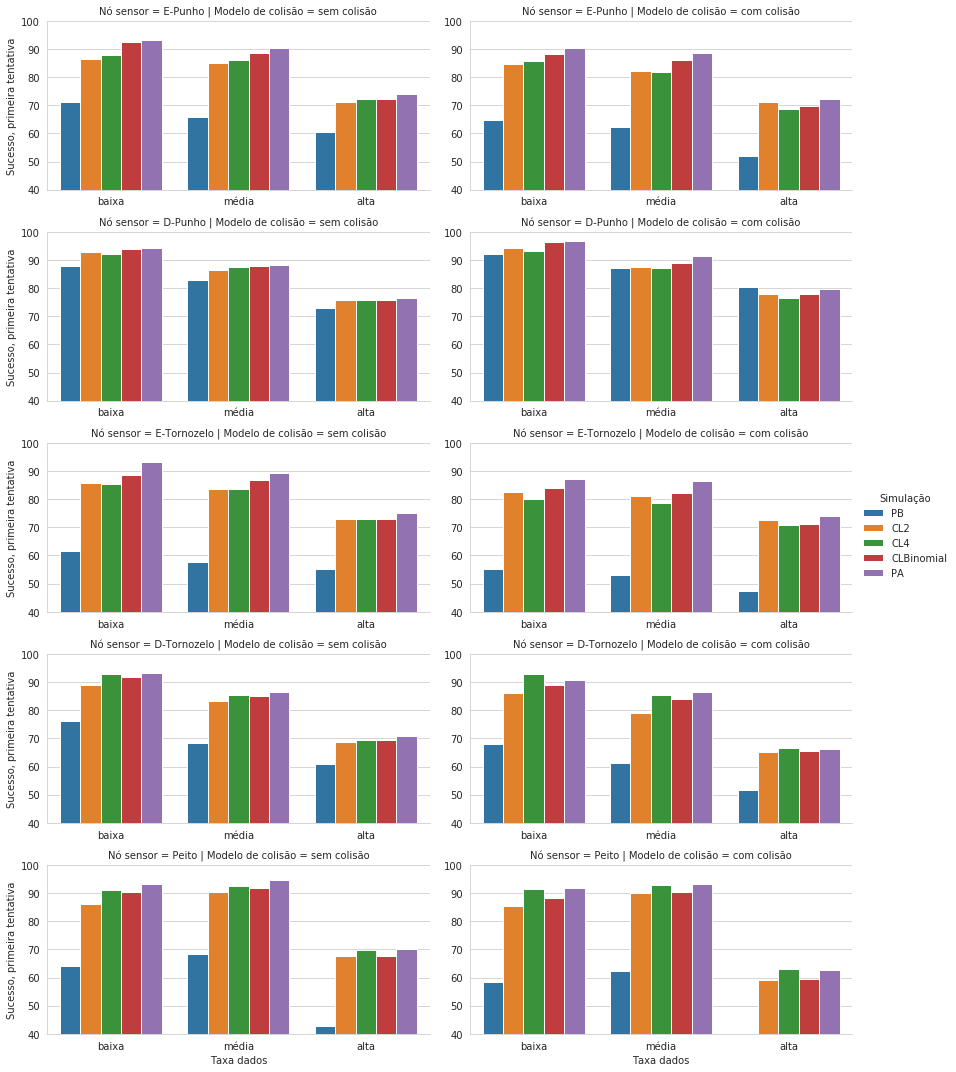

In [20]:
ax = sns.catplot(**chart_options)

ax.set(ylim=(40,100))

In [21]:
chart_options = dict(data=df_data,
                x='Nó sensor',
                y='Sucesso, primeira tentativa',
                hue='Simulação',
                hue_order=['PB', 'CL2', 'CL4','CLBinomial', 'PA'],
                row='Modelo de colisão',
                col='Taxa dados',
                col_order=['baixa', 'média', 'alta'],
                kind='bar',
                height=3,
                aspect=3,
                sharex=False,
                sharey=False
                )

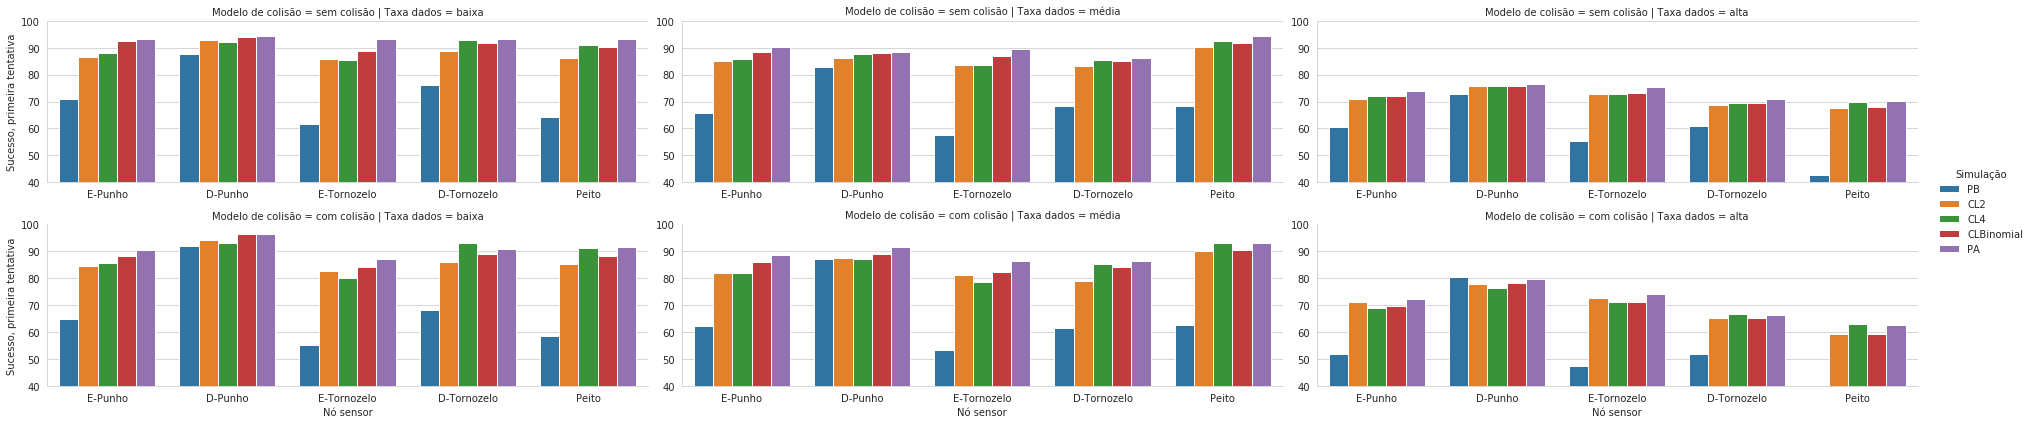

In [22]:
ax = sns.catplot(**chart_options)

ax.set(ylim=(40,100))

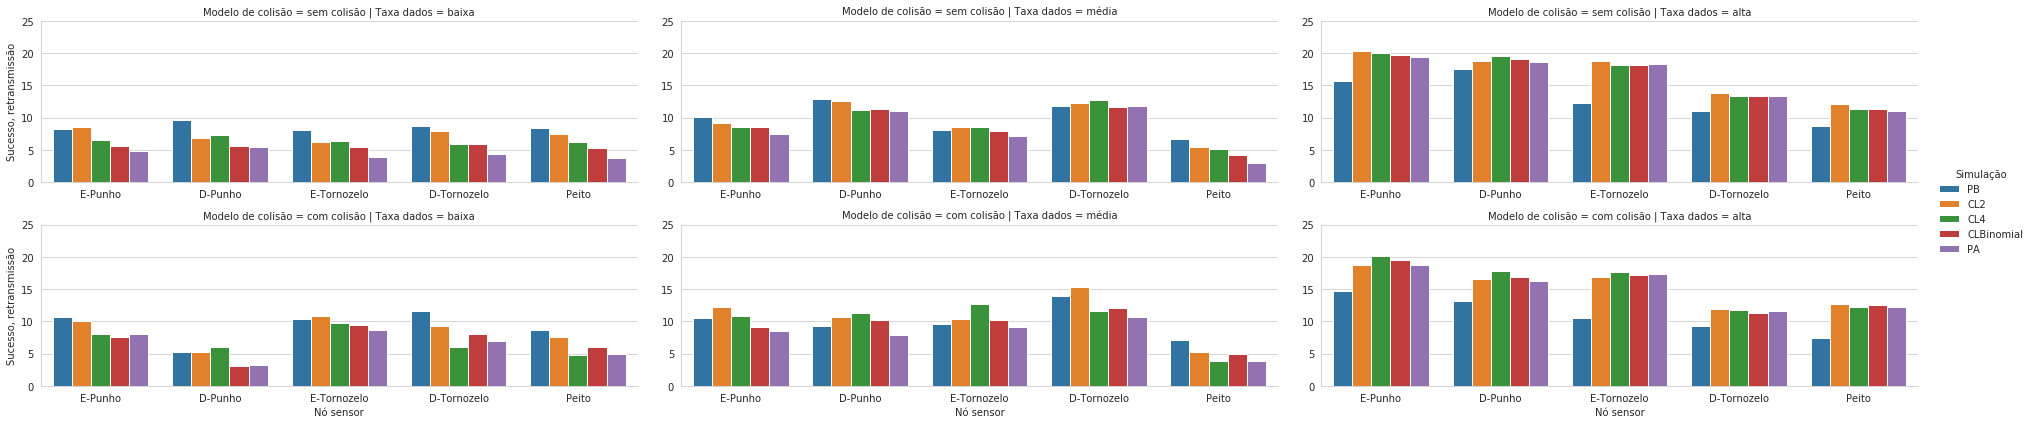

In [23]:
chart_options.update({'y' : 'Sucesso, retransmissão'})

ax = sns.catplot(**chart_options)

ax.set(ylim=(0,25))

In [24]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
Taxa dados                     150 non-null object
Modelo de colisão              150 non-null object
Nó sensor                      150 non-null object
Falha, estouro de buffer       150 non-null float64
Falha, canal ocupado           150 non-null float64
Falha, não recebimento ACK     150 non-null float64
Sucesso, primeira tentativa    150 non-null float64
Sucesso, retransmissão         150 non-null float64
Simulação                      150 non-null object
dtypes: float64(5), object(4)
memory usage: 10.6+ KB


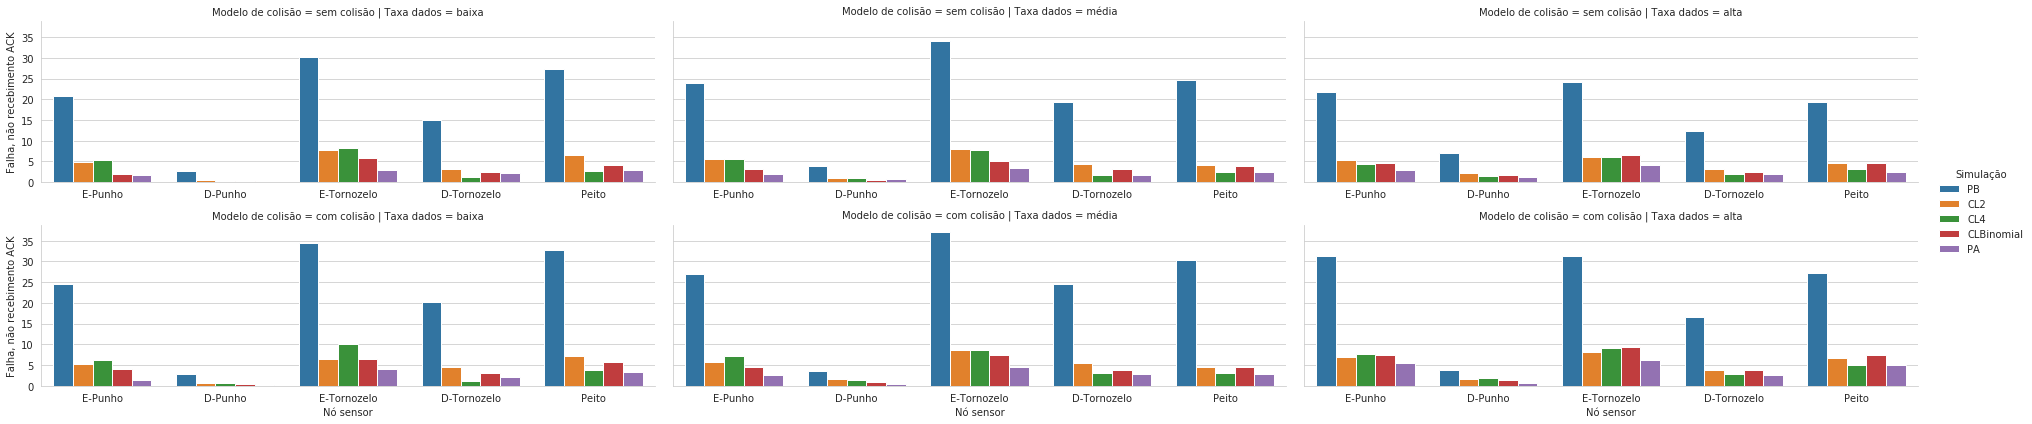

In [25]:
chart_options.update({'y' : 'Falha, não recebimento ACK', 'sharey' : True})

ax = sns.catplot(**chart_options)

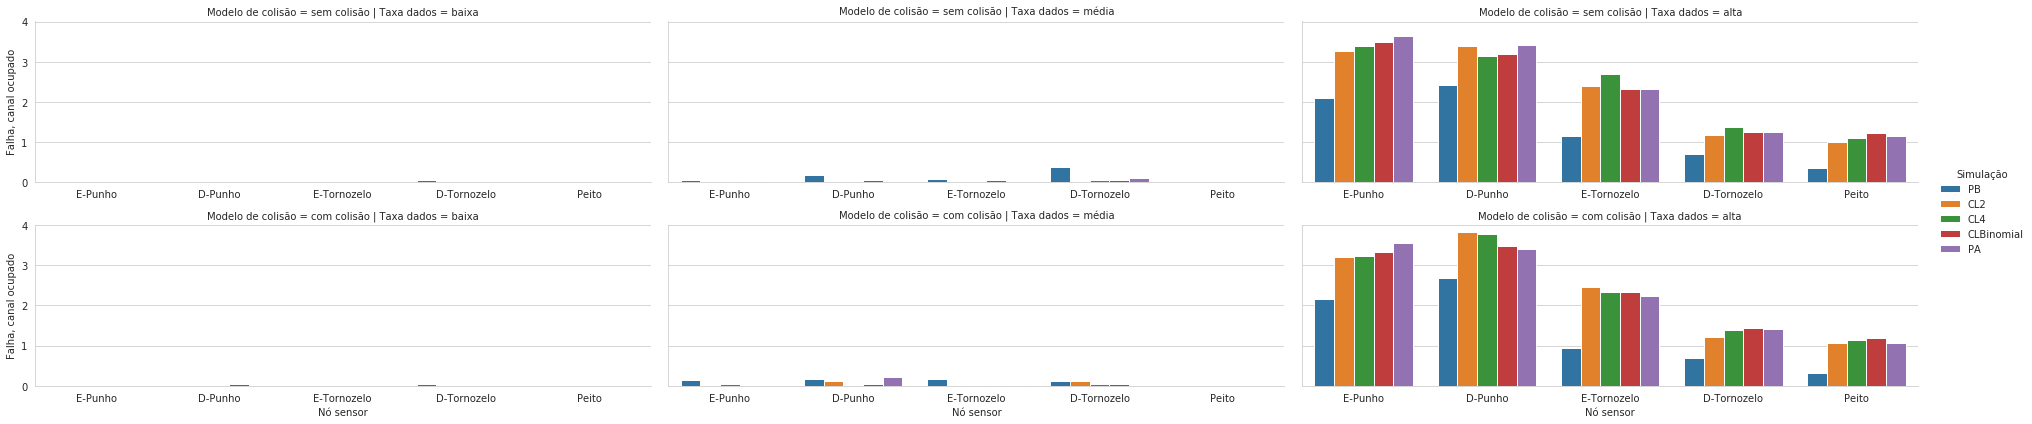

In [26]:
chart_options.update({'y' : 'Falha, canal ocupado', 'sharey' : True})

ax = sns.catplot(**chart_options)

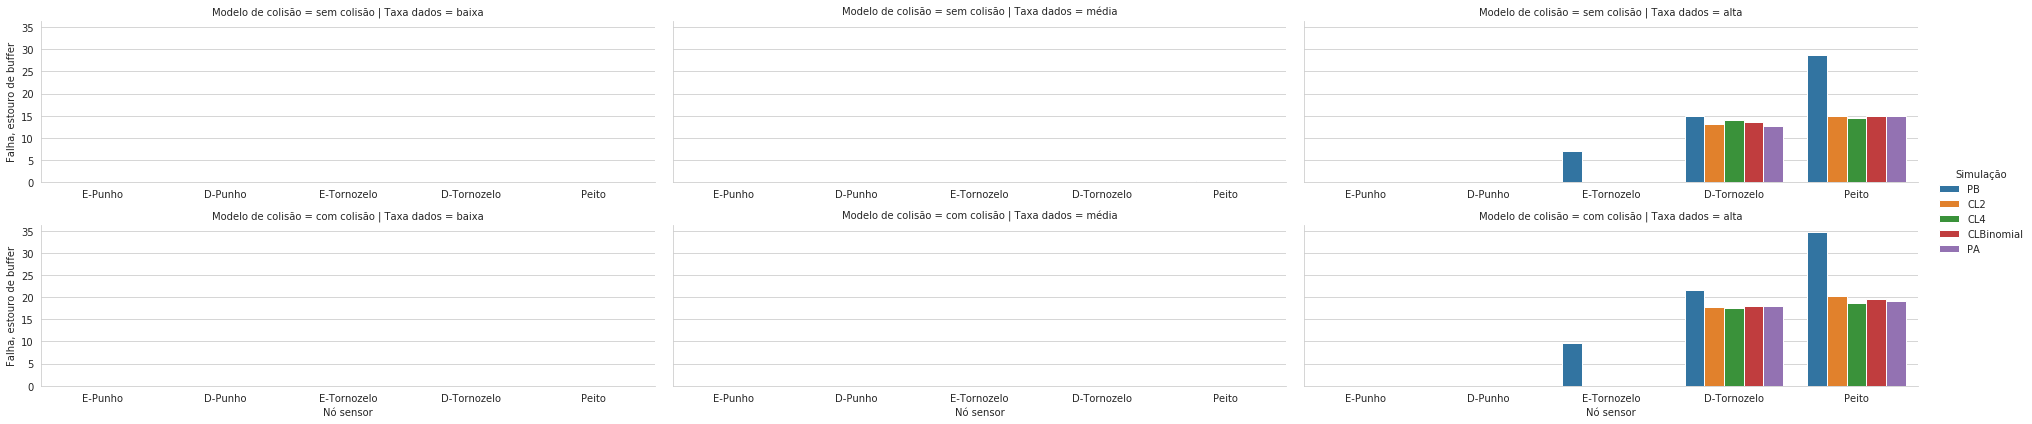

In [27]:
chart_options.update({'y' : 'Falha, estouro de buffer', 'sharey' : True})

ax = sns.catplot(**chart_options)

# ax.set(ylim=(0,25))

In [28]:
melted_data.columns

Index(['Modelo de colisão', 'Nó sensor', 'Taxa dados', 'Simulação',
       'Mac breakdown', 'Valor'],
      dtype='object')

In [29]:
melted_data['Mac breakdown'].unique()

array(['Falha, canal ocupado', 'Falha, estouro de buffer',
       'Falha, não recebimento ACK'], dtype=object)

In [30]:
chart_options = dict(
                x='Nó sensor',
                y='Valor',
                hue='Mac breakdown',
                col='Modelo de colisão',
                row='Simulação',
                col_order=['sem colisão', 'com colisão'],
                kind='bar',
                height=3,
                aspect=2,
                sharex=False,
                sharey=False
                )

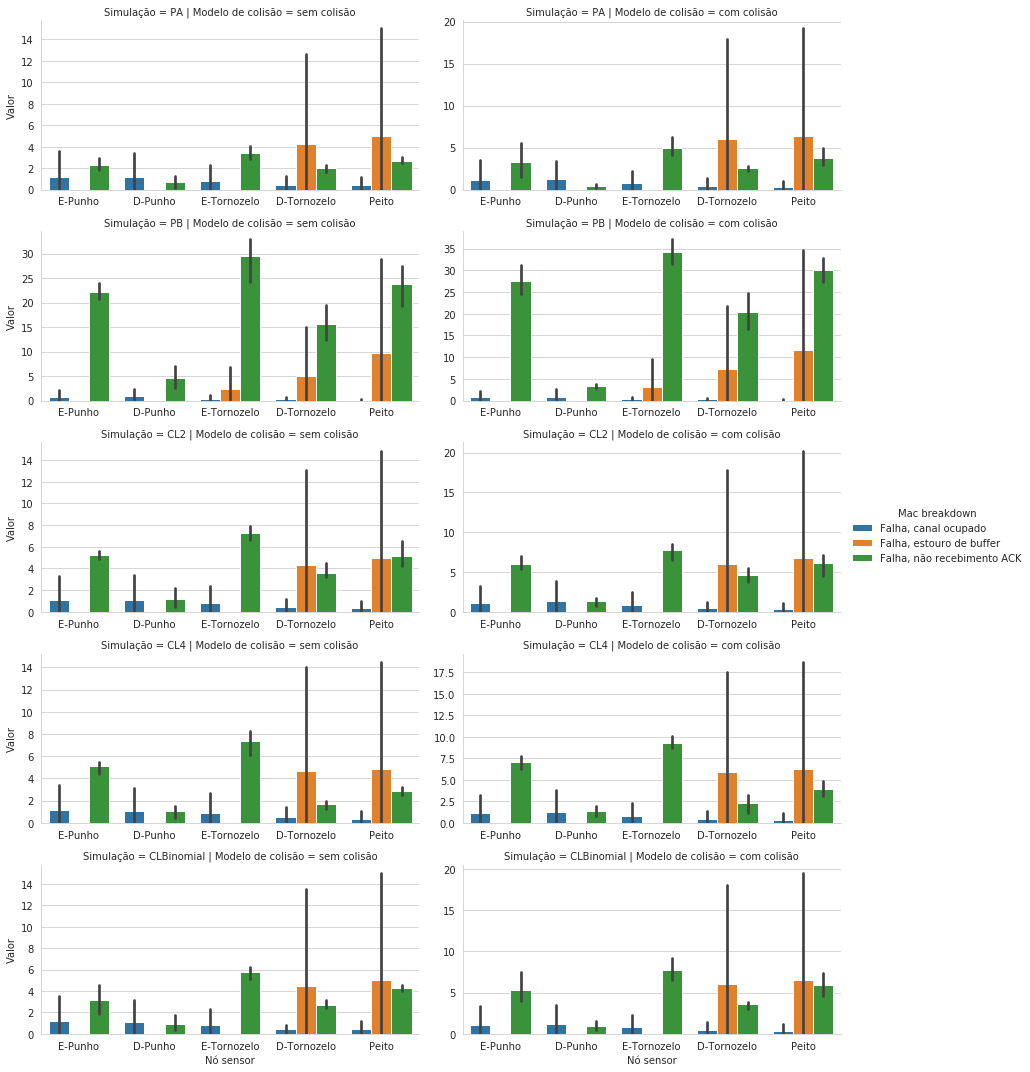

In [31]:
chart_options.update({'data' : melted_data })

sns.catplot(**chart_options)

In [32]:
melted_data['Taxa dados'].unique()

array(['alta', 'baixa', 'média'], dtype=object)

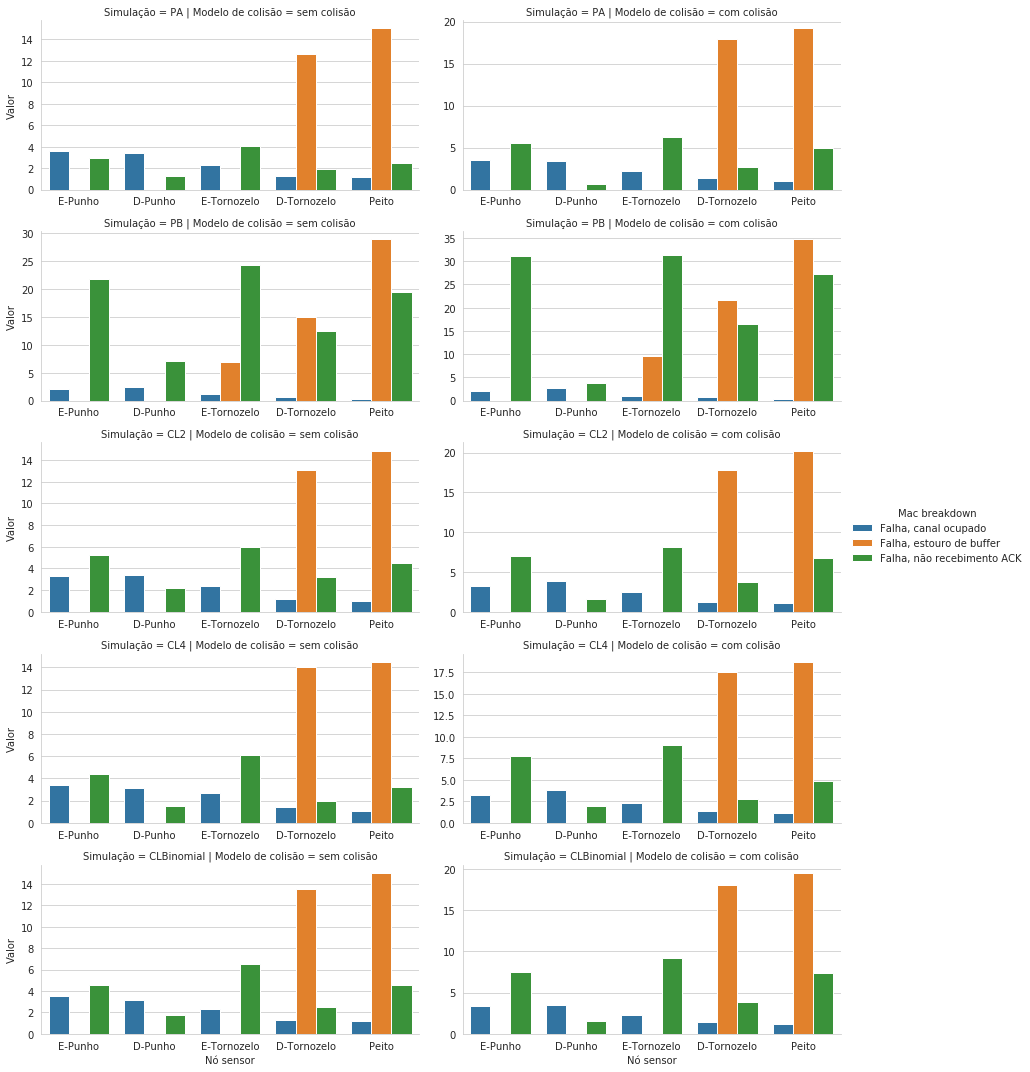

In [33]:
df = melted_data[melted_data['Taxa dados'] == 'alta']

chart_options.update({'data' : df })

sns.catplot(**chart_options)

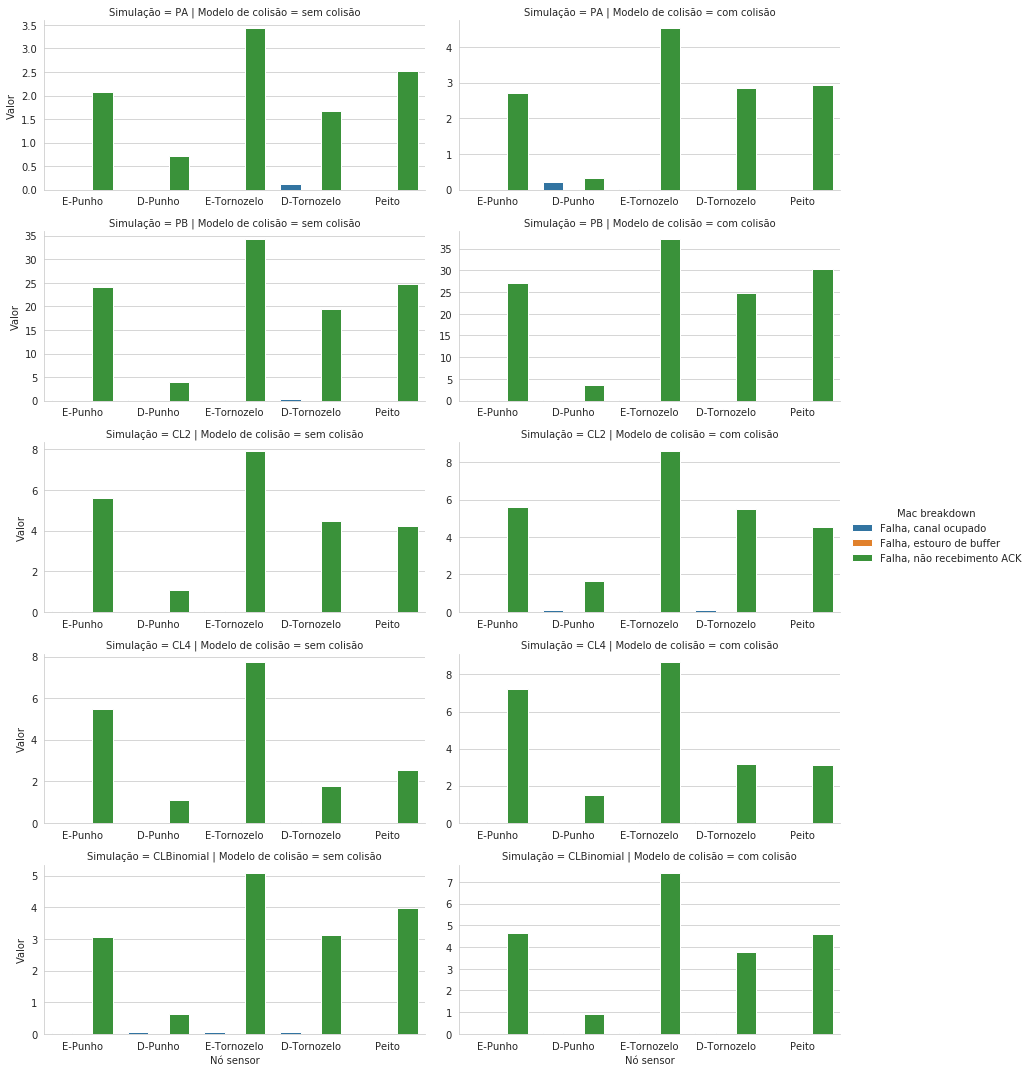

In [34]:
df = melted_data[melted_data['Taxa dados'] == 'média']

chart_options.update({'data' : df })

sns.catplot(**chart_options)

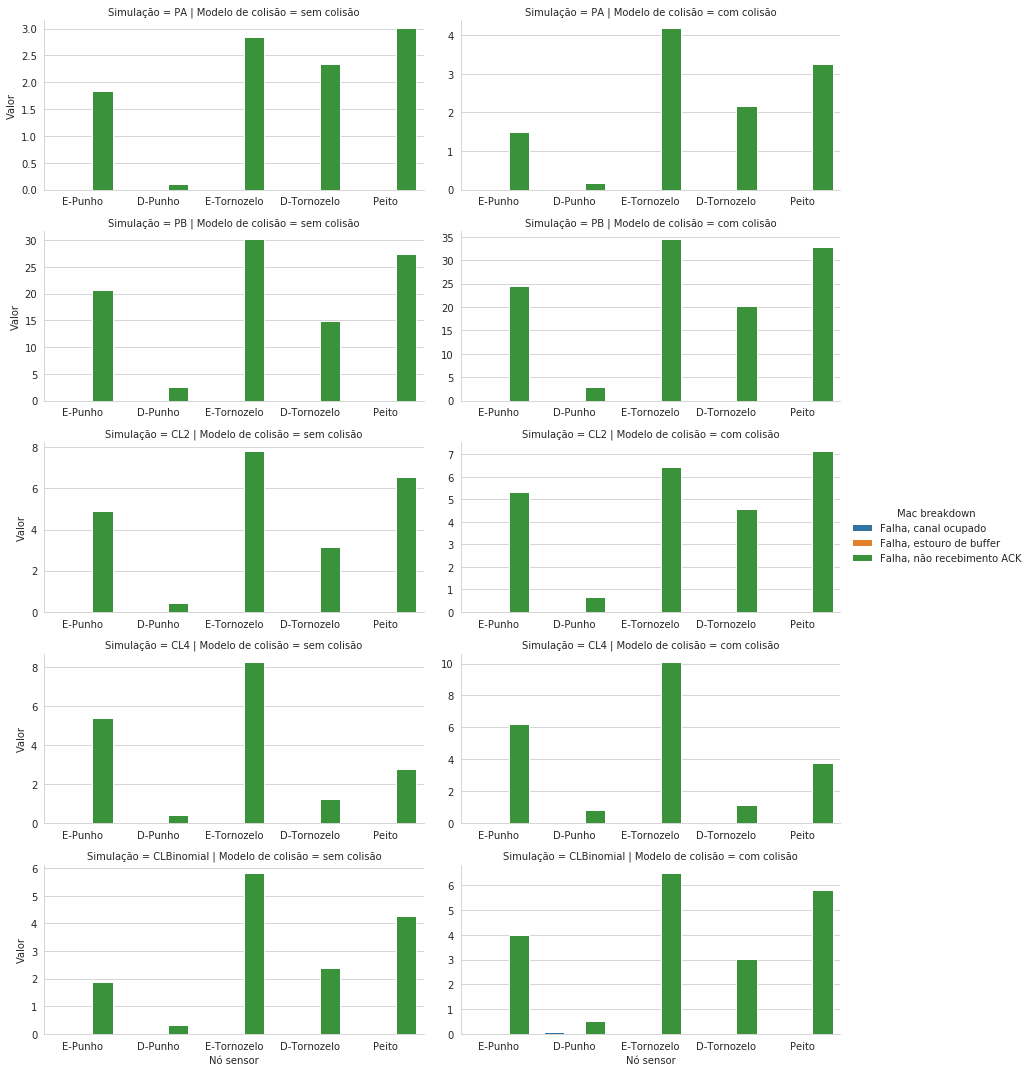

In [35]:
df = melted_data[melted_data['Taxa dados'] == 'baixa']

chart_options.update({'data' : df })

sns.catplot(**chart_options)

In [36]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
Taxa dados                     150 non-null object
Modelo de colisão              150 non-null object
Nó sensor                      150 non-null object
Falha, estouro de buffer       150 non-null float64
Falha, canal ocupado           150 non-null float64
Falha, não recebimento ACK     150 non-null float64
Sucesso, primeira tentativa    150 non-null float64
Sucesso, retransmissão         150 non-null float64
Simulação                      150 non-null object
dtypes: float64(5), object(4)
memory usage: 10.6+ KB


In [37]:
## Definindo estilo

plt.style.available

['seaborn-dark-palette',
 'fast',
 'seaborn-whitegrid',
 'seaborn-bright',
 'dark_background',
 'seaborn-poster',
 'classic',
 'fivethirtyeight',
 '_classic_test',
 'seaborn-darkgrid',
 'seaborn-notebook',
 'tableau-colorblind10',
 'Solarize_Light2',
 'seaborn-deep',
 'ggplot',
 'grayscale',
 'seaborn-ticks',
 'seaborn',
 'seaborn-paper',
 'seaborn-muted',
 'seaborn-white',
 'bmh',
 'seaborn-dark',
 'seaborn-colorblind',
 'seaborn-pastel',
 'seaborn-talk']

In [38]:
plt.style.use('seaborn-darkgrid')

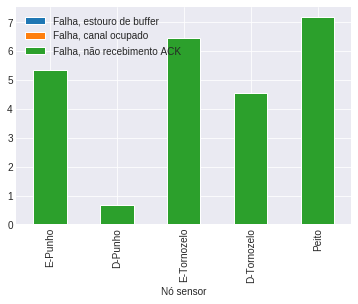

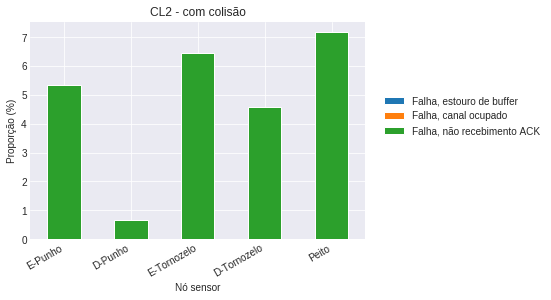

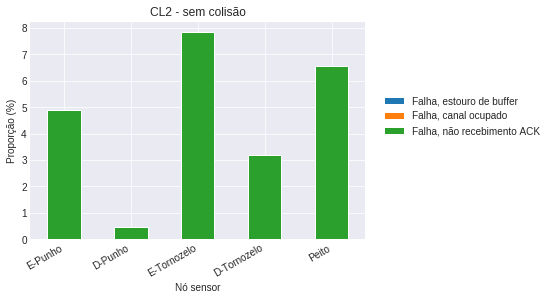

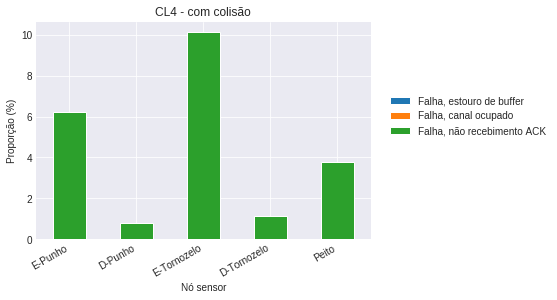

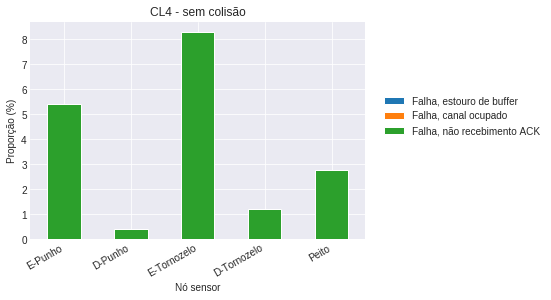

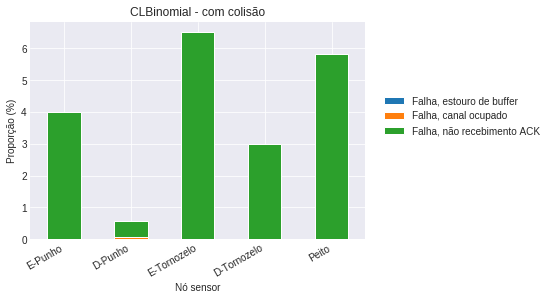

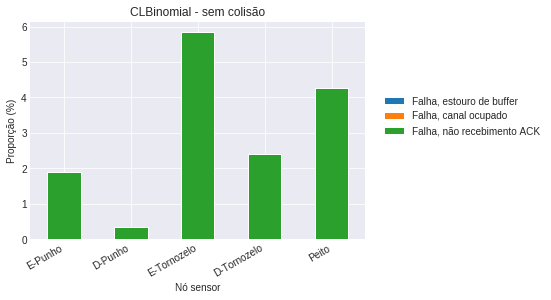

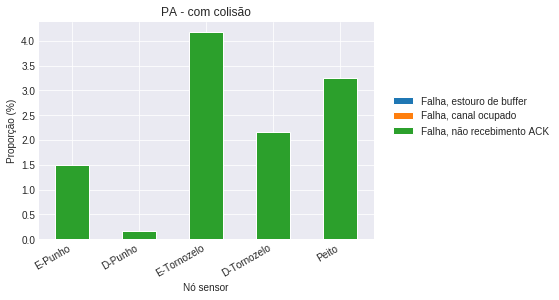

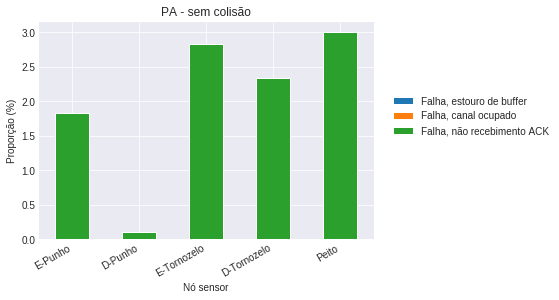

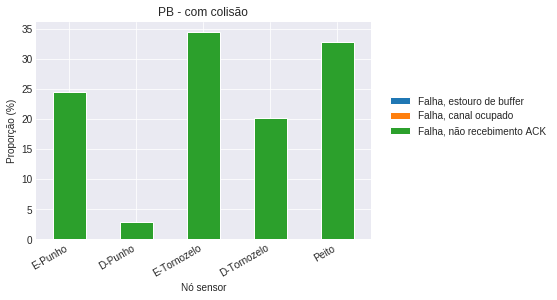

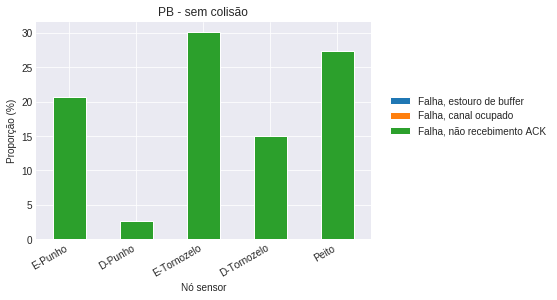

In [39]:
df = df_data[['Nó sensor','Simulação','Modelo de colisão','Taxa dados', 'Falha, estouro de buffer', 'Falha, canal ocupado', 'Falha, não recebimento ACK']]

select = df['Taxa dados'] == 'baixa'
df = df[select]

df = df.groupby(by=['Simulação', 'Modelo de colisão'])

# df.groups.keys()

axes = df.plot.bar(x="Nó sensor",stacked=True)

for t, ax in zip(df.groups.keys(),axes):
    simulacao, modelo_colisao = t
    ax.set(title=f'{simulacao} - {modelo_colisao}',ylabel='Proporção (%)')
    ax.legend(loc='upper right', bbox_to_anchor=(1.55,0.7))
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=30, horizontalalignment='right')

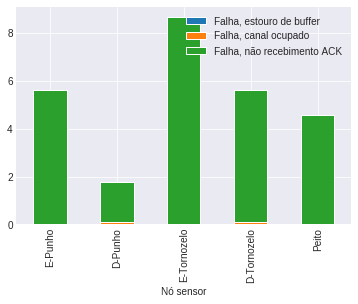

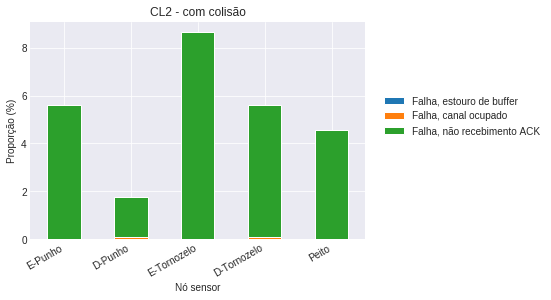

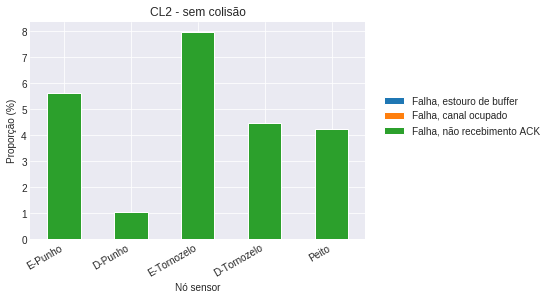

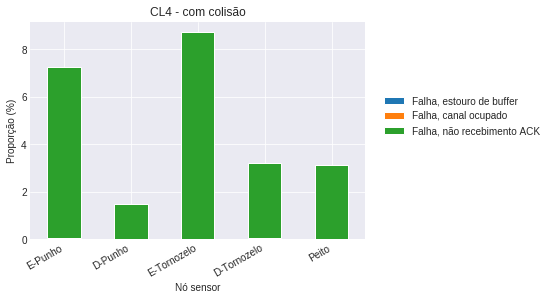

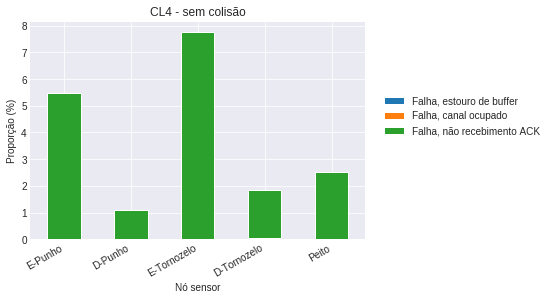

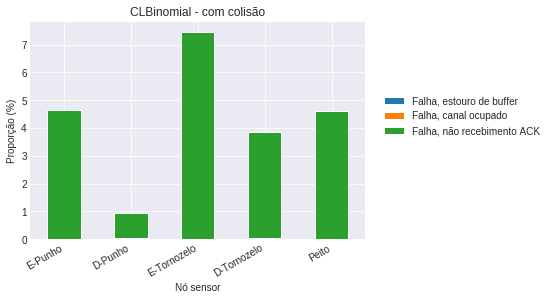

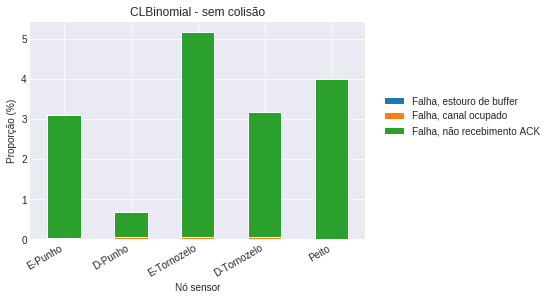

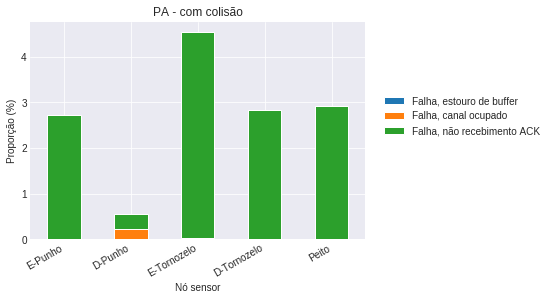

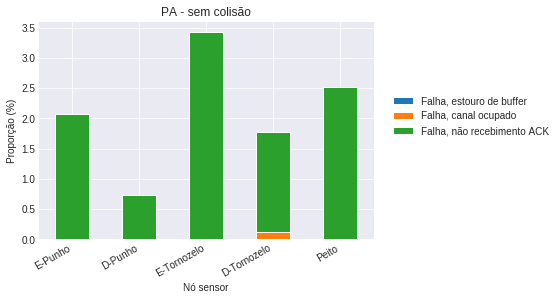

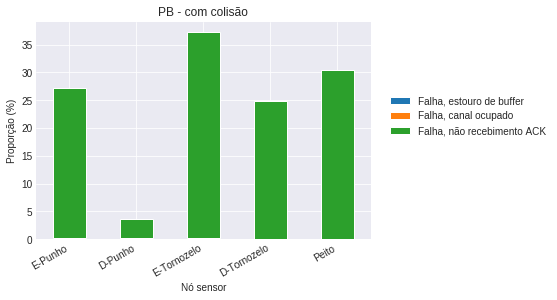

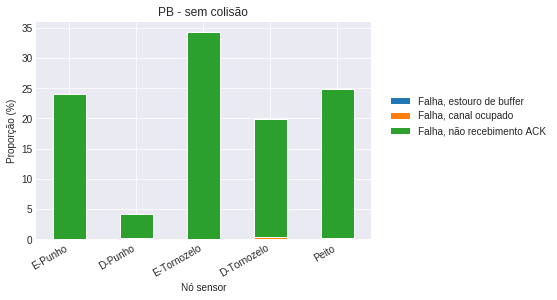

In [40]:
df = df_data[['Nó sensor','Simulação','Modelo de colisão','Taxa dados', 'Falha, estouro de buffer', 'Falha, canal ocupado', 'Falha, não recebimento ACK']]

select = df['Taxa dados'] == 'média'
df = df[select]

df = df.groupby(by=['Simulação', 'Modelo de colisão'])

# df.groups.keys()

axes = df.plot.bar(x="Nó sensor",stacked=True)

for t, ax in zip(df.groups.keys(),axes):
    simulacao, modelo_colisao = t
    ax.set(title=f'{simulacao} - {modelo_colisao}',ylabel='Proporção (%)')
    ax.legend(loc='upper right', bbox_to_anchor=(1.55,0.7))
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=30, horizontalalignment='right')

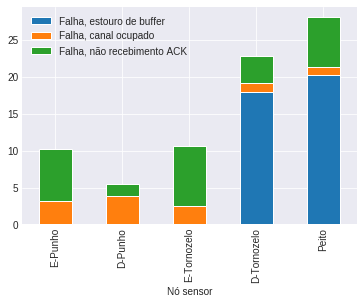

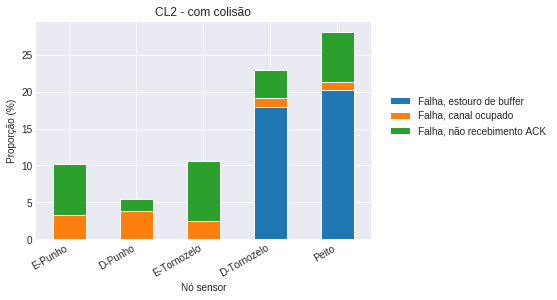

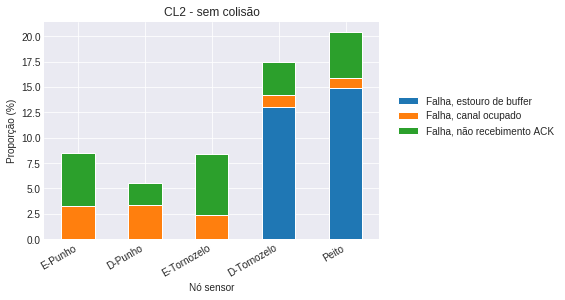

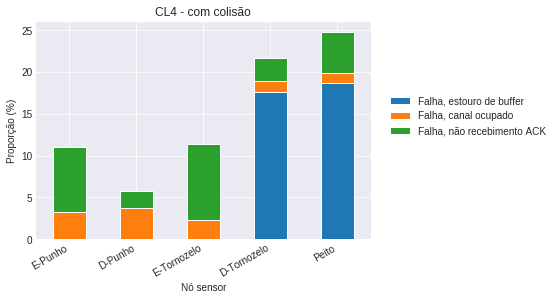

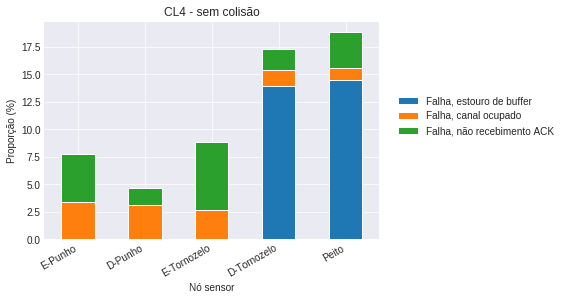

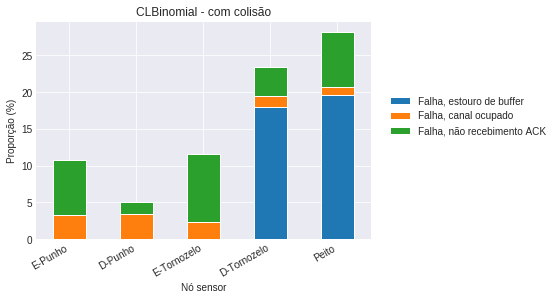

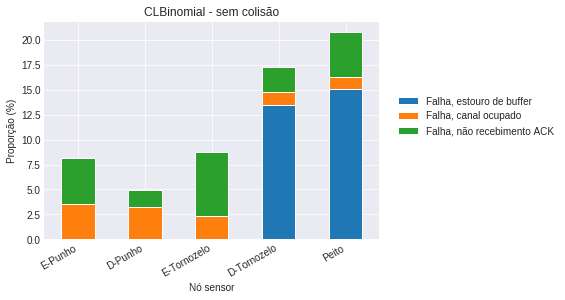

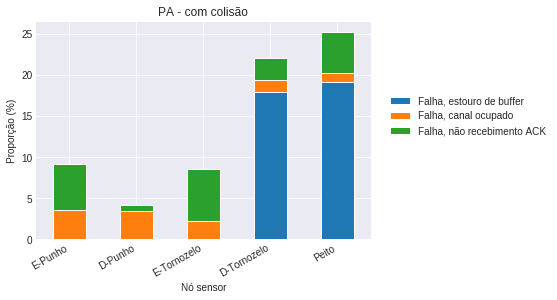

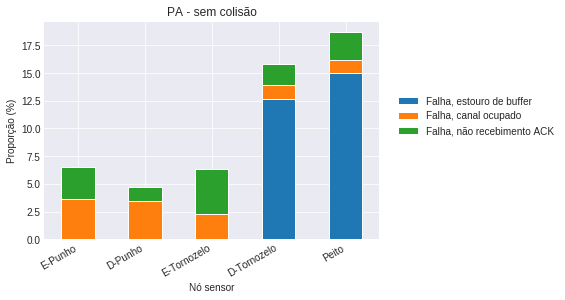

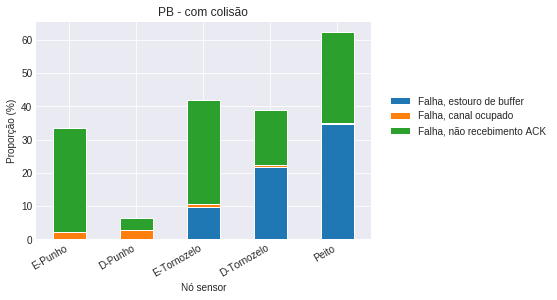

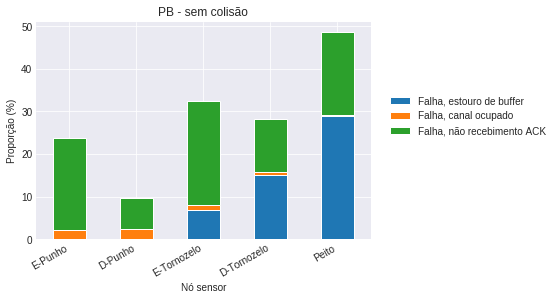

In [41]:
df = df_data[['Nó sensor','Simulação','Modelo de colisão','Taxa dados', 'Falha, estouro de buffer', 'Falha, canal ocupado', 'Falha, não recebimento ACK']]

select = df['Taxa dados'] == 'alta'
df = df[select]

df = df.groupby(by=['Simulação', 'Modelo de colisão'])

# df.groups.keys()

axes = df.plot.bar(x="Nó sensor",stacked=True)

for t, ax in zip(df.groups.keys(),axes):
    simulacao, modelo_colisao = t
    ax.set(title=f'{simulacao} - {modelo_colisao}',ylabel='Proporção (%)')
    ax.legend(loc='upper right', bbox_to_anchor=(1.55,0.7))
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=30, horizontalalignment='right')